# 匀速运动退化图像的复原

## 匀速运动参数的估计

常用的图像复原方法有逆滤波、维纳滤波、约束最小二乘方滤波、几何均值滤波，应用这些滤波法之前都需要先知道运动模糊的传递函数 $H(u, v)$，因此对运动参数的估计是滤波前必须完成的工作。在构造匀速运动退化滤波器时，我们引入的参数包括曝光时间 $T$、沿 $x$ 方向的移动量 $a$，沿 $y$ 方向的移动量 $b$。通常在拿到一幅照片时曝光时间是已知的，而移动量则是未知的，因此我们需要设法从图片中估计参数 $a, b$。

### 运动方向的估计

我们首先对一幅经理想退化滤波的图像和一幅实拍的退化图像，计算其频谱，观察运动模糊在频谱上的特征。

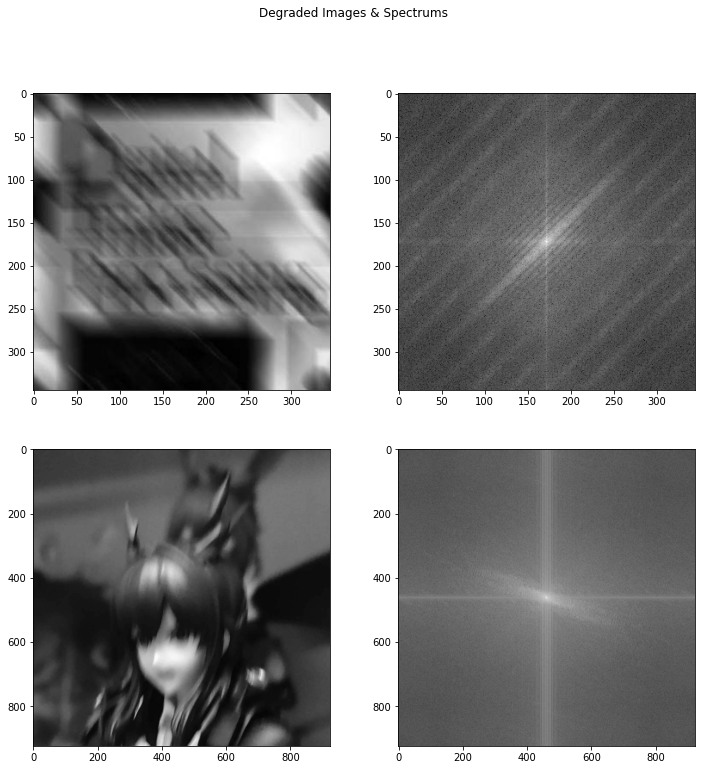

In [6]:
# 计算理想、实拍运动模糊图像的频谱
# 为了让频谱值更好被识别，显示之前对频谱取了对数
import matplotlib.pyplot as plt
import numpy as np

book_cover_filt = plt.imread('book_cover_filt.jpg')
book_cover_filt_fft = np.fft.fftshift(np.fft.fft2(book_cover_filt))

chen_figure_filt = plt.imread('chen_figure2.jpg')
chen_figure_filt_fft = np.fft.fftshift(np.fft.fft2(chen_figure_filt))

fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('Degraded Images & Spectrums')
ax11.imshow(book_cover_filt, cmap='gray')
ax12.imshow(np.log(np.abs(book_cover_filt_fft)), cmap='gray')
ax21.imshow(chen_figure_filt, cmap='gray')
ax22.imshow(np.log(np.abs(chen_figure_filt_fft)), cmap='gray')

我们容易在频谱中发现，具有运动模糊特征的图像的频谱中，除集中包含图像本身信息的十字亮线外，还有一条较亮的斜线。这条斜线是由于运动模糊产生的，与退化滤波器的频谱图像相对应，故可以从斜线中采集到关于运动参数的信息。

仍然使用基本原理的建模方法，我们从退化传递函数下手，观察频谱与函数中参数的关系。

$$ H(u, v) = \frac{T}{\pi (ua+vb)} \sin[\pi (ua+vb)] \mathrm{e}^{-\mathrm{j}\pi (ua+vb)} $$

由于我们对频谱取了模，上式可以写为模的形式

$$ |H(u, v)| = \left| \frac{T}{\pi (ua+vb)} \sin[\pi (ua+vb)] \right| $$

我们取 $T = 1$，并将 $ua+vb$ 换成 $x$，绘制出 $|H(u, v)|$ 与 $x$ 关系的图像。

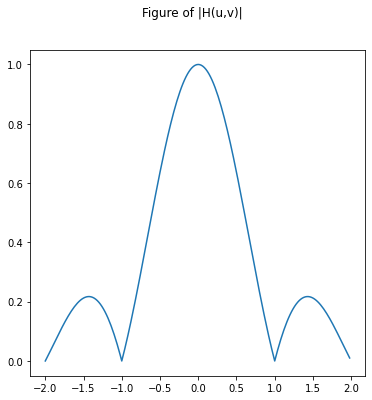

In [11]:
# 绘制|H(u,v)|的图像
T = 1

def evaluate_H_mod(x: float) -> float:
    if x == 0:
        return T
    return abs(T / (np.pi * x) * np.sin(np.pi * x))

x = [0 for i in range(200)]
H = [0 for i in range(200)]
x_step = 4 / 200
for i in range(200):
    x[i] = -2 + x_step * i
    H[i] = evaluate_H_mod(x[i])

fig, ax = plt.subplots(1, figsize=(6, 6))
fig.suptitle('Figure of |H(u,v)|')
ax.plot(x, H)

容易发现，这一函数在 $x=ua+vb=0$ 处取得最大值 $T$。因此，频谱中的斜线对应的就是 $ua+vb=0$ 直线，其斜率 $k=-\dfrac{b}{a}$ 可代表运动的方向。但频谱中无法提供关于运动距离的信息，我们仍然需要考虑使用其他方法。

### 运动距离的估计

通过观察，我们还可以发现，如果将图片沿运动方向平移，在恰好平移运动距离长度后会出现自相关极小峰值。这是因为，在平移长度不超过运动距离时，图像中仍然有一部分因运动模糊产生的拖影重合；而长度等于运动距离时，重合恰好消失。我们可以利用这一原理估计运动的距离。

以上面的图例进行测试，`book_cover_filt.jpg` 一图运动方向为 -45°，而 `chen_figma2.jpg` 一图约为 22°。

E:\Temp\ipykernel_2852\1439923947.py:12: RuntimeWarning: overflow encountered in ubyte_scalars
  result += img[i][j] * img[nx][ny]


KeyboardInterrupt: 

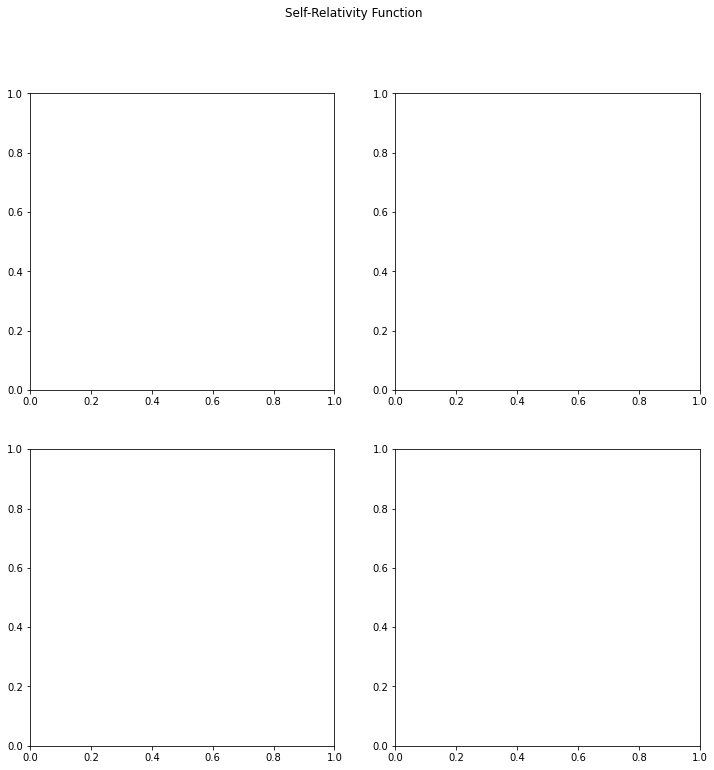

In [14]:
from typing import List

def get_relativity(img: List[List], dir: float, shift: float) -> float:
    n, m = (len(img), len(img[0]))
    x_shift, y_shift = (-shift * np.sin(dir), shift * np.cos(dir))
    result = 0.0
    for i in range(n):
        for j in range(m):
            (nx, ny) = (round(i + x_shift), round(j + y_shift))
            if nx < 0 or nx >= n or ny < 0 or ny >= m:
                continue
            result += img[i][j] * img[nx][ny]
    return result

fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('Self-Relativity Function')

x = [0 for i in range(100)]
R1 = [0 for i in range(100)]
R2 = [0 for i in range(100)]
x_step = 4 / 100

for i in range(100):
    x[i] = -2 + i * x_step
    R1[i] = get_relativity(book_cover_filt, -np.pi / 4, x[i])
    R2[i] = get_relativity(chen_figure_filt, np.pi / 180 * 22, x[i])

ax11.imshow(book_cover_filt, cmap='gray')
ax12.plot(x, R1)
ax21.imshow(chen_figure_filt, cmap='gray')
ax22.plot(x, R2)